# Климатическая модель Global T2m

<p>Модель была реализована в 2020 г., предназначена для прогнозирования глобальной температуры воздуха на Земле.</p>
<p>В качестве входящих факторов использованы 5 климатических показателей, которые были предобработаны (произведено смещение, замена вычисленными рядами с определенными характеристиками).</p>
<p>Для прогнозирования каждого показателя была создана отдельная модель, результаты предсказаний которых использовались в модели Global T2m.</p>
<p>Модель была интегрирована в BI-систему, в которой входящие данные автоматически загружались из источников, предсказания модели пересчитывались и визуализировались.</p>
<p>Данный документ демонстрирует принципы построения ML-модели, не раскрывая методику, ссылки на использовавшиеся научные работы, данные и произведенные с ними преобразования.</p>

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import phik
from phik.report import plot_correlation_matrix

1.25.0


### Загрузка данных

In [2]:
# Загружаем данные из файлов
t2m = pd.read_csv('datasets/t2m_global.csv', sep=';', decimal=',', names=['date', 't2m'], index_col=[0], parse_dates=[0], date_format='%d.%m.%Y')
df_1 = pd.read_csv('datasets/feature_1.csv', sep=';', decimal=',', names=['date', 'feature_1'], index_col=[0], parse_dates=[0], date_format='%d.%m.%Y')
df_2 = pd.read_csv('datasets/feature_2.csv', sep=';', decimal=',', names=['date', 'feature_2'], index_col=[0], parse_dates=[0], date_format='%d.%m.%Y')
df_3 = pd.read_csv('datasets/feature_3.csv', sep=';', decimal=',', names=['date', 'feature_3'], index_col=[0], parse_dates=[0], date_format='%d.%m.%Y')
df_4 = pd.read_csv('datasets/feature_4.csv', sep=';', decimal=',', names=['date', 'feature_4'], index_col=[0], parse_dates=[0], date_format='%d.%m.%Y')
df_5 = pd.read_csv('datasets/feature_5.csv', sep=';', decimal=',', names=['date', 'feature_5'], index_col=[0], parse_dates=[0], date_format='%d.%m.%Y')

### Предобработка данных

In [3]:
# Функция для подсчета пропусков в столбцах датафрейма
def check_na(df):
    cols_na = pd.DataFrame(columns=['column','count'])
    for col in df.columns:
        print(col, df[col].isna().sum())

#### t2m

In [4]:
# Выведем информацию о полях датафрейма
t2m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1500 entries, 2024-12-31 to 1900-01-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   t2m     1500 non-null   int64
dtypes: int64(1)
memory usage: 23.4 KB


In [5]:
# Проверим датафрейм на пропуски
check_na(t2m)

t2m 0


#### feature_1

In [6]:
# Выведем информацию о полях датафрейма
df_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 732 entries, 2030-12-31 to 1970-01-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  732 non-null    float64
dtypes: float64(1)
memory usage: 11.4 KB


In [7]:
# Проверим датафрейм на пропуски
check_na(df_1)

feature_1 0


#### feature_2

In [8]:
# Выведем информацию о полях датафрейма
df_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 558 entries, 2025-12-31 to 1979-07-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_2  558 non-null    float64
dtypes: float64(1)
memory usage: 8.7 KB


In [9]:
# Проверим датафрейм на пропуски
check_na(df_2)

feature_2 0


#### feature_3

In [10]:
# Выведем информацию о полях датафрейма
df_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 558 entries, 2025-12-31 to 1979-07-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_3  558 non-null    float64
dtypes: float64(1)
memory usage: 8.7 KB


In [11]:
# Проверим датафрейм на пропуски
check_na(df_3)

feature_3 0


#### feature_4

In [12]:
# Выведем информацию о полях датафрейма
df_4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 552 entries, 2025-12-31 to 1980-01-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_4  552 non-null    float64
dtypes: float64(1)
memory usage: 8.6 KB


In [13]:
# Проверим датафрейм на пропуски
check_na(df_4)

feature_4 0


#### feature_5

In [14]:
# Выведем информацию о полях датафрейма
df_5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 672 entries, 2025-12-31 to 1970-01-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_5  672 non-null    float64
dtypes: float64(1)
memory usage: 10.5 KB


In [15]:
# Проверим датафрейм на пропуски
check_na(df_5)

feature_5 0


### Исследовательский анализ

#### t2m

<p>Таргет - средняя температура воздуха над поверхностью суши.</p>

In [16]:
t2m['t2m'].describe()

count    1500.000000
mean       18.376000
std        48.915073
min       -90.000000
25%       -16.000000
50%         5.000000
75%        45.000000
max       186.000000
Name: t2m, dtype: float64

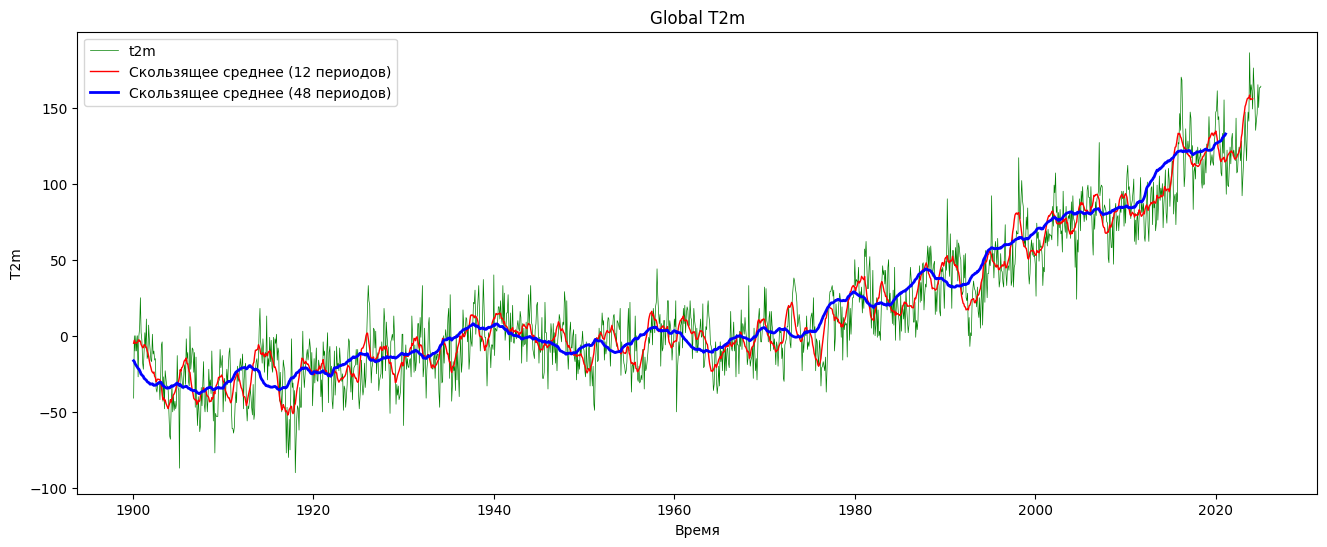

In [42]:
# Выведем график показателя
plt.figure(figsize=(16, 6))

# Скользящее среднее
rolling_mean_12 = t2m['t2m'].rolling(window=12).mean()
rolling_mean_48 = t2m['t2m'].rolling(window=48).mean()

sns.lineplot(x=t2m.index, y=t2m['t2m'], label='t2m', color='green', lw=0.5).set(title='Global T2m', xlabel='Время', ylabel='T2m');
sns.lineplot(x=rolling_mean_12.index, y=rolling_mean_12, label='Скользящее среднее (12 периодов)', color='red', lw=1)
sns.lineplot(x=rolling_mean_48.index, y=rolling_mean_48, label='Скользящее среднее (48 периодов)', color='blue', lw=2)

plt.show();

<p>На графике виден тренд к повышению температуры воздуха.</p>
<p>Среднее значение '48 периодов' имеет горизонтальный участок в период с 1940 г. по 1978 г.</p>
<p>Среднее значение '12 периодов' колеблется относительно среднего '48 периодов'.</p>

### Объединение таблиц

In [18]:
# Объединим таблицы
data = pd.merge(t2m, df_1, on='date', how='inner')
data = pd.merge(data, df_2, on='date', how='inner')
data = pd.merge(data, df_3, on='date', how='inner')
data = pd.merge(data, df_4, on='date', how='inner')
data = pd.merge(data, df_5, on='date', how='inner')

In [19]:
# Проверим объединенный датафрейм на наличие пропусков
check_na(data)

t2m 0
feature_1 0
feature_2 0
feature_3 0
feature_4 0
feature_5 0


<p>Пропусков в данных не обнаружено.</p>

### Корреляционный анализ

In [20]:
# Количественные признаки
numerical_cols = ['feature_1',
                  'feature_2',
                  'feature_3',
                  'feature_4',
                  'feature_5']

# Категорийные признаки
categorical_cols = []

# Таргет
target = ['t2m']

# Список признаков для проведения корреляционного анализц
phik_cols = target + numerical_cols + categorical_cols

In [21]:
# вычисление коэффициентов корреляции phi для датафрейма train_features
phik_overview = data[phik_cols].phik_matrix(interval_cols=numerical_cols+target)

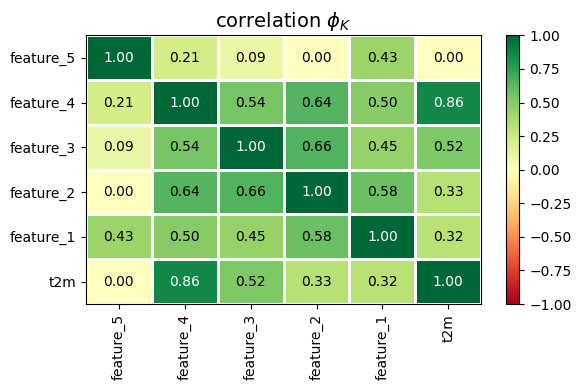

In [22]:
# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1,
    figsize=(6, 4)
)

<p>Наибольшую корреляцию с таргетом имеют признаки:</p>
<ul>
    <li>feature_4</li>
    <li>feature_3</li>
</ul>
<p>Мультиколлинеарности среди признаков не наблюдается.</p>

### Разделение на выборки

In [23]:
# Дата начала тестовых данных
test_start_date = '2014-12-31'

data = data.sort_index()

# Отделяем обучающий период
train_df = data.loc[:test_start_date]

# Отделяем тестовый период
test_df = data.loc[test_start_date:]

# Формируем обучающую выборку
X_train = train_df.drop(columns=['t2m'])
y_train = train_df.t2m

# Формируем тестовую выборку
X_test = test_df.drop(columns=['t2m'])
y_test = test_df.t2m

print('Размер тестовой выборки:', round(len(X_test)/len(X_train),2))

Размер тестовой выборки: 0.29


### Создание пайплайна

<p>Все входные признаки являются числовыми. В пайплайне оставим только подготовку числовых признаков.</p>

In [24]:
# Создаём пайплайн для подготовки признаков из списка numerical_cols
num_pipe = Pipeline(
    [('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
     ('num', StandardScaler())
    ]
)

# Создаём общий пайплайн для подготовки данных с num
data_preprocessor = ColumnTransformer(
    [('num', num_pipe, numerical_cols)
    ], 
    remainder='passthrough'
)

In [25]:
# Инициализируем модель
pipe = Pipeline([
              ('preprocessor', data_preprocessor),
              ('model', LinearRegression())
             ])

# TimeSeriesSplit для кросс-валидации по временным рядам
tscv = TimeSeriesSplit(n_splits=3)

### Обучение модели

In [26]:
%%time

# Вычислим метрику mse на кросс-валидации
mse = -cross_val_score(pipe,
                       X_train,
                       y_train,
                       cv=tscv,
                       scoring='neg_mean_squared_error')

CPU times: user 154 ms, sys: 222 ms, total: 376 ms
Wall time: 57.4 ms


In [27]:
# Вычислим метрику rmse
rmse = np.sqrt(mse.mean())

# Выведем rmse модели на обучающих данных
print('RMSE модели: ', round(rmse, 2))

RMSE модели:  18.94


In [28]:
%%time

# Обучим модель на тренировочной выборке
pipe.fit(X_train, y_train)

CPU times: user 6.29 ms, sys: 1.43 ms, total: 7.72 ms
Wall time: 5.17 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleImputer_num',
                                                                   SimpleImputer()),
                                                                  ('num',
                                                                   StandardScaler())]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3', 'feature_4',
                                                   'feature_5'])])),
                ('model', LinearRegression())])

### Проверка на тестовой выборке

In [29]:
%%time

# Выполним предсказание на обучающей выборке
y_pred_train = pipe.predict(X_train)

# Выполним предсказание на тестовой выборке
y_pred_test = pipe.predict(X_test)

CPU times: user 3.48 ms, sys: 949 µs, total: 4.43 ms
Wall time: 3.78 ms


In [30]:
# Вычислим RMSE для тестовой выборки
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("RMSE на тестовых данных:", round(rmse, 4))

RMSE на тестовых данных: 19.7305


### Оценка важности признаков

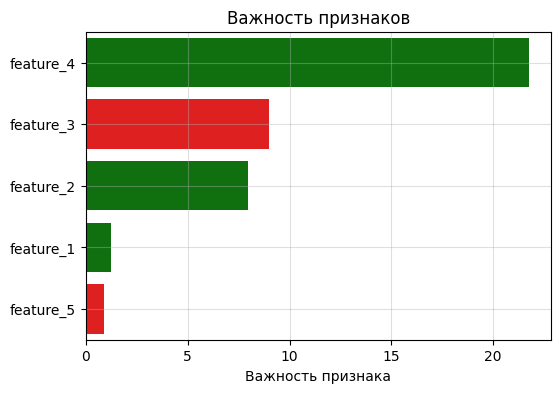

In [31]:
# Получим коэффициенты модели
coefficients = pipe.named_steps['model'].coef_

# Выведем важность признаков
feature_importances = dict(zip(X_train.columns, coefficients))
sorted_importances = sorted(feature_importances.items(), key=lambda x: abs(x[1]), reverse=True)

# Подготавим данные для графика
features, importances = zip(*sorted_importances)
colors = ['green' if imp > 0 else 'red' for imp in importances]
abs_importances = [abs(imp) for imp in importances]  # Получаем абсолютные значения

# Выведем график
plt.figure(figsize=(6, 4))
sns.barplot(x=abs_importances, y=features, hue=features, palette=colors, legend=False)
plt.xlabel('Важность признака')
plt.title('Важность признаков')
plt.grid(alpha=0.4)
plt.show()

<p>Наиболее важные признаки:</p>
<ul>
    <li>feature_4 - положительное влияние на таргет.</li>
    <li>feature_3 - отрицательное влияние.</li>
    <li>feature_2 - положительное влияние.</li>
</ul>
<p>Наиболее важные признаки имеют наибольшую корреляцию с таргетом (см. Корреляционный анализ).</p>

### Вывод графика модели

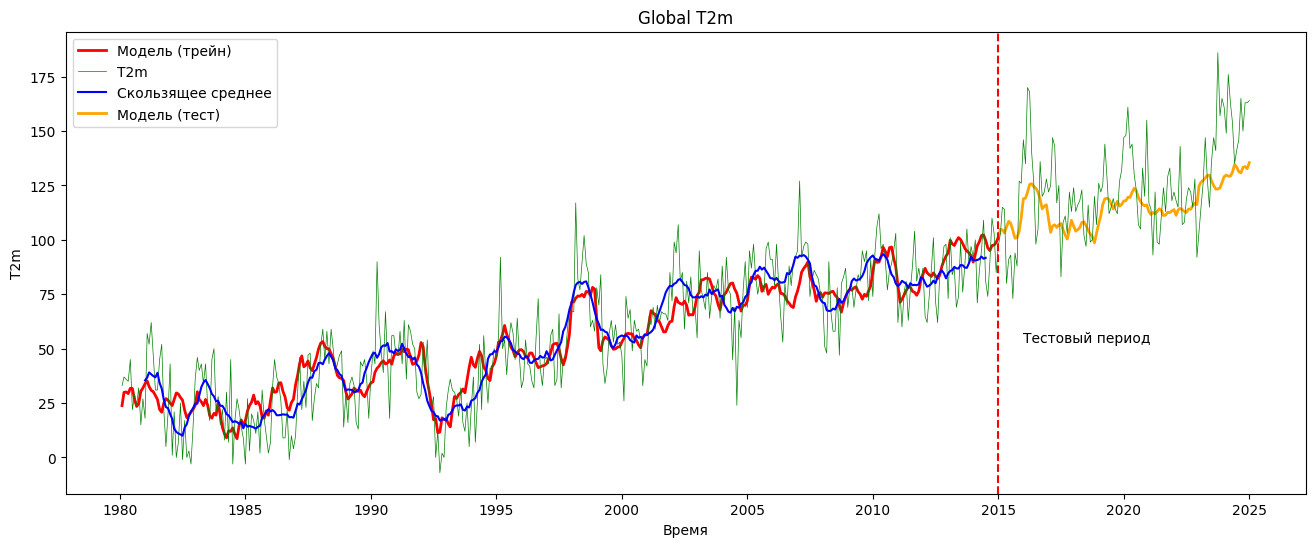

In [40]:
# Выведем график, демонстрирующий работу модели
plt.figure(figsize=(16, 6))

# Тренировочный период 
sns.lineplot(y=y_pred_train, x=train_df.index, label='Модель (трейн)', color='red', lw=2).set(title='Global T2m', xlabel='Время', ylabel='T2m');
sns.lineplot(data=train_df['t2m'], label='T2m', color='green', lw=0.5)

# Скользящее среднее
rolling_mean_train = train_df['t2m'].shift(periods=-6).rolling(window=12).mean()
sns.lineplot(x=rolling_mean_train.index, y=rolling_mean_train, label='Скользящее среднее', color='blue', lw=1.5)

# Тестовый период
sns.lineplot(y=y_pred_test, x=test_df.index, label='Модель (тест)', color='orange', lw=2).set(title='Global T2m', xlabel='Время', ylabel='T2m');
sns.lineplot(data=test_df['t2m'], color='green', lw=0.5)

plt.axvline(x=pd.to_datetime('2014-12-31'), color='red', linestyle='--')

plt.text(x=pd.to_datetime('2016-01-01'), y=test_df['t2m'].min()-20, s='Тестовый период', color='black')

plt.show();

<p>На графике видно, что модель хорошо объясняет среднее значение таргета.</p>
<p>Вычислим корреляцию между скользящим средим значением таргета и предсказанным значением на трейне.</p>

In [41]:
# Преобразуем y_pred_train в Series
y_pred_train_series = pd.Series(y_pred_train, index=train_df.index)

# Рассчитаем корреляцию
correlation = round(rolling_mean_train.corr(y_pred_train_series), 2)

print(f"Корреляция между скользящим средним и предсказаниями модели: {correlation}")

Корреляция между скользящим средним и предсказаниями модели: 0.95


## Выводы

<p>В ходе работы над моделью были выполнены следующие действия:</p>
<ul>
    <li>Загружены необходимые библиотеки.</li>
    <li>Загружены данных из csv-файлов.</li>
    <li>Проведена предобработка данных: проведена проверка на пропуски, корретность типов данных.</li>
    <li>Проведен исследовательский анализ таргета.</li>
    <li>Произведено объединение таблиц.</li>
    <li>Проведен корреляционный анализ признаков. Выявлены признаки с наибольшей корреляцией с таргетом, проведена проверка признаков на мультиколлинеарность (мультиколлинеарность не обнаружена).</li>
    <li>Произведено разделение данных на обучающую и тестовую выборки.</li>
    <li>Создан пайплайн.</li>
    <li>Вычислено значение метрики RMSE на кросс-валидации на обучающей выборке. Метрика RMSE равна 18,94.</li>
    <li>Обученная модель проверена на тестовой выборке. Метрика RMSE равна 19,73.</li>
    <li>Произведена оценка важности признаков. Наиболее важны признаки: feature_4, feature_3, feature_2.</li>
    <li>Выведен график модели с добавлением скользящего среднего таргета (12 периодов).</li>
    <li>Вычислен коэффициент корреляции Пирсона между предсказанными значениями на тестовом периоде и скользящим средним. <b>Значение r2 равно 0.95</b> (очень сильная зависимость).</li>
</ul>

## Общий вывод по модели

<p>Анализ результатов модели говорит о ее практической применимости для предсказания среднесрочных и долгосрочных тенденций при прогнозировании глобальной температуры воздуха, а также для прогнозирования сезонных температурных условий.</p>